In [70]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from astropy.io import fits
from astropy.visualization import ImageNormalize, MinMaxInterval, ZScaleInterval, LogStretch, make_lupton_rgb
from astropy.visualization.wcsaxes import add_scalebar
from astropy.wcs import WCS
import astropy.units as u

In [160]:
field = "GDS"
filters = {'b':'f150w', 'g':'f277w', 'r':'f444w'}

b_hdu = fits.open(glob.glob(f"/home/aurelien/DAWN/DJA_SE++/image/{field}/cutout/*{filters['b']}*sci*.fits")[0], memmap=True)[0]
g_hdu = fits.open(glob.glob(f"/home/aurelien/DAWN/DJA_SE++/image/{field}/cutout/*{filters['g']}*sci*.fits")[0], memmap=True)[0]
r_hdu = fits.open(glob.glob(f"/home/aurelien/DAWN/DJA_SE++/image/{field}/cutout/*{filters['r']}*sci*.fits")[0], memmap=True)[0]

min_x = min(b_hdu.header["NAXIS1"], g_hdu.header["NAXIS1"], r_hdu.header["NAXIS1"])
if b_hdu.header["NAXIS1"] > min_x:
    print("B channel pixel scale is too high ! Down-sampling")
    b_image = b_hdu.data[::2,::2]
else: 
    b_image = b_hdu.data
    wcs = WCS(b_hdu.header)
if g_hdu.header["NAXIS1"] > min_x:
    print("G channel pixel scale is too high ! Down-sampling")
    g_image = g_hdu.data[::2,::2]
else: 
    g_image = g_hdu.data
    wcs = WCS(g_hdu.header)
if r_hdu.header["NAXIS1"] > min_x:
    print("R channel pixel scale is too high ! Down-sampling")
    r_image = r_hdu.data[::2,::2]
else: 
    r_image = r_hdu.data
    wcs = WCS(r_hdu.header)

B channel pixel scale is too high ! Down-sampling


In [161]:
rgb = np.stack([1.0*r_image/np.max(r_image), 0.3*g_image/np.max(g_image), 1.0*b_image/np.max(b_image)], axis=-1)

In [162]:
def add_good_scalebar(ax, wcs, color='white', fraction=0.25, fontsize='x-large', pad=0.1):
    width = abs(wcs.pixel_scale_matrix[0,0]*wcs.pixel_shape[0])*u.degree
    good_values = [0.5*u.arcsec, 1*u.arcsec, 2*u.arcsec, 3*u.arcsec, 5*u.arcsec, 10*u.arcsec, 20*u.arcsec,
                   0.5*u.arcmin, 1*u.arcmin, 2*u.arcmin, 3*u.arcmin, 5*u.arcmin, 10*u.arcmin, 20*u.arcmin,
                   0.5*u.degree, 1*u.degree, 2*u.degree, 5*u.degree, 10*u.degree]
    dist = np.array([(fraction*width-val).value for val in good_values])
    dist[dist<0] = np.inf
    size = good_values[np.argmin(dist)]
    add_scalebar(ax, size, label=f"{size:latex}", color=color, fontproperties=FontProperties(size=fontsize), label_top=True, pad=pad, size_vertical=fontsize/2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


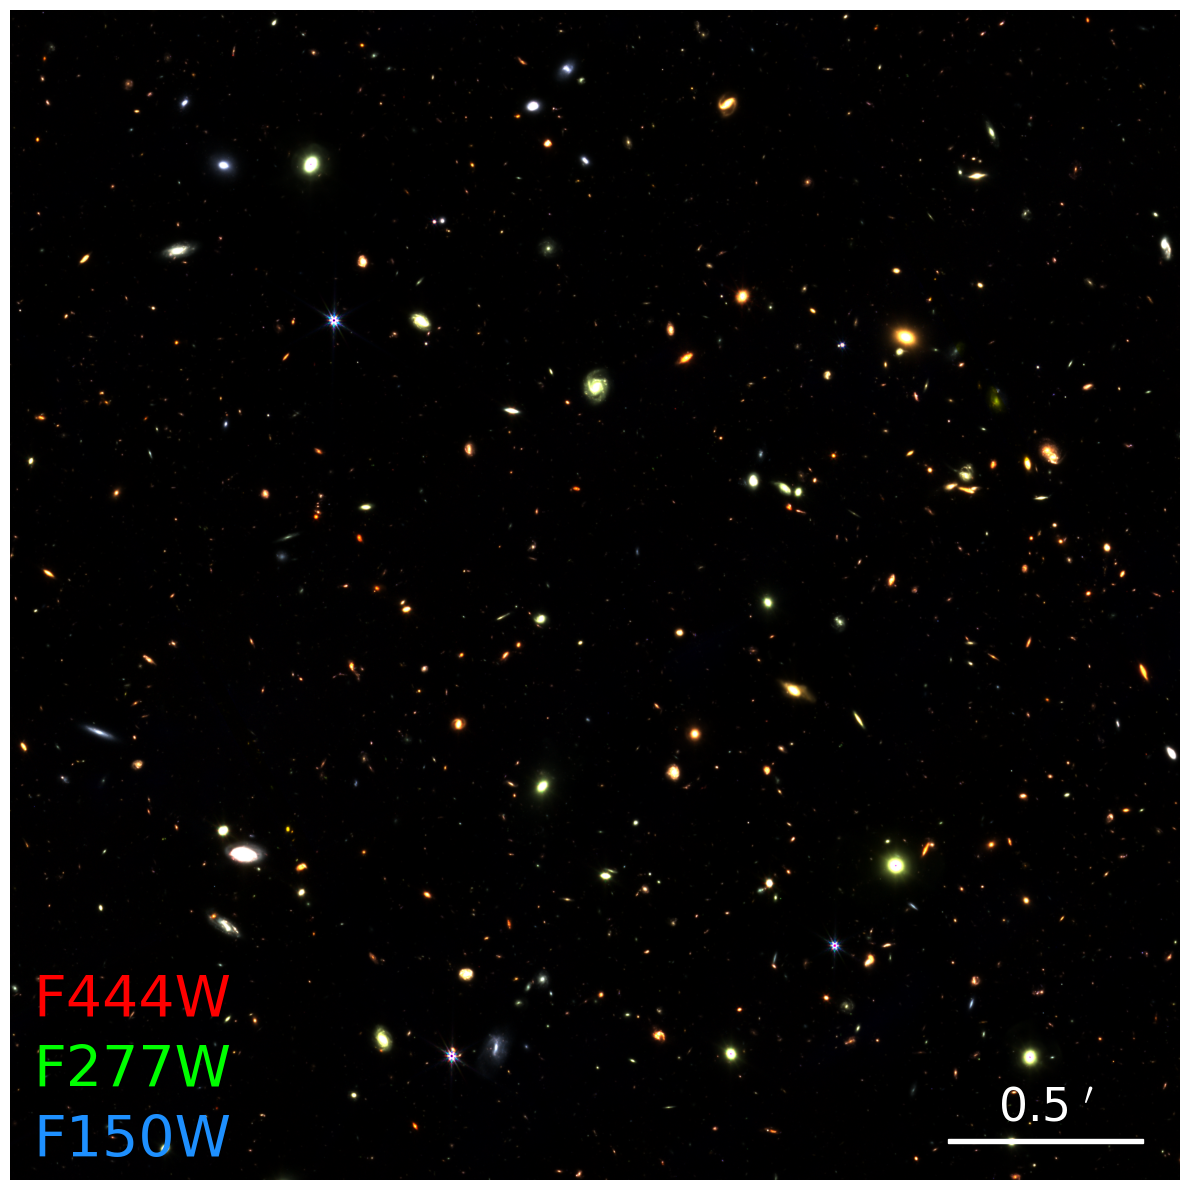

In [163]:
# %matplotlib ipympl
fig, ax = plt.subplots(figsize=(12,12), subplot_kw={'projection':wcs})
# norm = ImageNormalize(rgb, interval=ZScaleInterval())
norm = ImageNormalize(rgb, interval=MinMaxInterval(), stretch=LogStretch())
ax.imshow(255*rgb, origin='lower', norm=norm)
y1, y2 = ax.get_window_extent().get_points()[:,1]
y = rgb.shape[0]
fontsize = 200 * (y2-y1)/y
ax.text(0.02, 0.02, filters['b'].upper(), transform=ax.transAxes, color='dodgerblue', fontsize=fontsize)
ax.text(0.02, 0.08, filters['g'].upper(), transform=ax.transAxes, color='lime', fontsize=fontsize)
ax.text(0.02, 0.14, filters['r'].upper(), transform=ax.transAxes, color='red', fontsize=fontsize)
ax.set_axis_off()
add_good_scalebar(ax, wcs, fontsize=0.8*fontsize, pad=0.01*fontsize)
fig.tight_layout()
fig.savefig(f"/home/aurelien/DAWN/DJA_SE++/{field}.png", bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()